In [89]:
import os
os.chdir('/home/sunwookim/codes/RobustMixGen')

In [90]:
from dataset import create_dataset, create_sampler, create_loader
import argparse
import ruamel.yaml as yaml
import torch
import numpy as np
from matplotlib import pyplot as plt
import json
import os 
import argparse
import ruamel.yaml as yaml
import torch
import numpy
import numpy as np
from matplotlib import pyplot as plt
import json
import os 
import random

In [91]:
parser = argparse.ArgumentParser()     
parser.add_argument('--config', default='./configs/Retrieval_coco_romix.yaml')
parser.add_argument('--output_dir', default='output/Retrieval_full_romix_wj')        
parser.add_argument('--checkpoint', default='')   
parser.add_argument('--text_encoder', default='bert-base-uncased')
parser.add_argument('--evaluate', action='store_true')
parser.add_argument('--device', default='cuda')
parser.add_argument('--seed', default=42, type=int)
parser.add_argument('--world_size', default=1, type=int, help='number of distributed processes')    
parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
parser.add_argument('--distributed', default=True, type=bool)
args = parser.parse_args([])

config = yaml.load(open(args.config, 'r'), Loader=yaml.Loader)
config['output_dir'] = args.output_dir

In [92]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import json 
import yaml 
import pandas as pd 

from dataset.caption_dataset import re_train_dataset, re_eval_dataset, pretrain_dataset
from dataset.nlvr_dataset import nlvr_dataset
from dataset.ve_dataset import ve_dataset
from dataset.vqa_dataset import vqa_dataset
from dataset.grounding_dataset import grounding_dataset

from dataset.randaugment import RandomAugment

from augmentation import create_romixgen 

In [93]:
train_dataset, val_dataset, test_dataset = create_dataset('re', config)  

/home/sunwookim/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:853: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/home/sunwookim/.local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [94]:
len(train_dataset.romixgen.obj_bg_dict["obj"]), len(train_dataset.romixgen.obj_bg_dict["bg"]), len(train_dataset.romixgen.obj_bg_dict["unusable_bg"])

(118248, 2961, 2078)

In [95]:
# romixgen에 대한 정보 추출 진행
import pandas as pd
img_info = pd.DataFrame(train_dataset.romixgen.image_info_dict).transpose()

In [96]:
img_info.head()

,file_name,width,height,max_obj_super_cat,max_obj_cat,max_obj_area,max_obj_midpoint,max_obj_bbox,max_obj_area_portion,captions,mop,obj_bg
57870,COCO_train2014_000000057870.jpg,640,480,"[furniture, furnitures]","[chair, chairs]",23717,"[176.59, 375.745]","[90.67, 271.49, 171.84, 208.51]",0.0772038,[A restaurant has modern wooden tables and cha...,0.116635,obj
384029,COCO_train2014_000000384029.jpg,640,429,"[person, people]","[person, people]",87957.8,"[243.905, 154.24499999999998]","[4.82, 2.89, 478.17, 302.71]",0.320359,[A man preparing desserts in a kitchen covered...,0.527196,obj
222016,COCO_train2014_000000222016.jpg,480,640,"[person, people]","[person, people]",32991.7,"[288.43, 390.96]","[225.29, 185.04, 126.28, 411.84]",0.107395,[a big red telephone booth that a man is stand...,0.169294,obj
520950,COCO_train2014_000000520950.jpg,640,427,"[appliance, appliances]","[oven, ovens]",18047.5,"[142.815, 366.89]","[50.97, 309.67, 183.69, 114.44]",0.0660404,"[the kitchen is full of spices on the rack, A ...",0.0769229,obj
69675,COCO_train2014_000000069675.jpg,640,480,"[person, people]","[person, people]",71105.4,"[437.39, 258.875]","[309.57, 44.22, 255.64, 429.31]",0.231463,[A child and woman are cooking in the kitchen....,0.357255,obj


In [97]:
img_info.iloc[0]['captions']

['A restaurant has modern wooden tables and chairs.',
 'A long restaurant table with rattan rounded back chairs.',
 'a long table with a plant on top of it surrounded with wooden chairs ',
 'A long table with a flower arrangement in the middle for meetings',
 'A table is adorned with wooden chairs with blue accents.']

In [98]:
mop_og = img_info["max_obj_area_portion"].copy()
mop_ch = img_info["mop"].copy()

In [99]:
mop_og.sort_values(inplace=True)
mop_og.reset_index(drop=True, inplace=True)
mop_ch.sort_values(inplace=True)
mop_ch.reset_index(drop=True, inplace=True)

In [100]:
def center_check(midpoint: list, width: int, height: int, thrs: float):
    width_area = [0 + width * ((1 - thrs) / 2), width - width * ((1 - thrs) / 2)]
    height_area = [
        0 + height * ((1 - thrs) / 2),
        height - height * ((1 - thrs) / 2),
    ]
    try:
        if midpoint[0] > width_area[0] and midpoint[0] < width_area[1]:
            if midpoint[1] > height_area[0] and midpoint[1] < height_area[1]:
                return True
            else:
                return False
        else:
            return False
    except:
        return False

def romixgen_preset( img_info_dict, obj_bg_threshold=0.01, bg_center_threshold=0.7 ):
    seg_or_bbox = "bbox"
    for key in img_info_dict.keys():
        try:
            max_obj_area_portion = img_info_dict[key]["max_obj_area_portion"]
            max_obj_midpoint = img_info_dict[key]["max_obj_midpoint"]
            img_width, img_height = int(img_info_dict[key]["width"]), int(img_info_dict[key]["height"])
            """try:
                max_obj_area_portion = (img_info_dict[key]["max_obj_bbox"][2] * img_info_dict[key]["max_obj_bbox"][3])/(img_width * img_height)
            except:
                max_obj_area_portion = None"""
            img_info_dict[key]["mop"] = max_obj_area_portion
            if max_obj_area_portion:
                img_info_dict[key].pop( "max_obj_segment_points", None ) if seg_or_bbox == "bbox" else img_info_dict[key].pop("max_obj_bbox", None)
                if ( max_obj_area_portion > obj_bg_threshold):  # 물체가 이미지의 일정 비율 이상 차지하는 경우
                    img_info_dict[key]["obj_bg"] = "obj"
                else:
                    if center_check( max_obj_midpoint, img_width, img_height, bg_center_threshold):  # 빈 곳의 중심이 이미지의 중심에 가까운 경우
                        img_info_dict[key]["obj_bg"] = "bg"
                    else:  # 빈 곳의 중심이 이미지의 중심에 가깝지 않은 경우 (외곽에 위치한 경우)
                        img_info_dict[key]["obj_bg"] = "unusable_bg"
            else:  # max obj 비어있는 경우 (그냥 unusable bg로 저장)
                img_info_dict[key]["obj_bg"] = "unusable_bg"
        except Exception as e:
            print(f"Error processing image {img_info_dict[key]['file_name']}: {e}")
    obj_bg_dict = {}

    # obj,bg key를 가진 dictionary 생성
    for key in img_info_dict.keys():
        if img_info_dict[key]["obj_bg"] not in obj_bg_dict:
            obj_bg_dict[img_info_dict[key]["obj_bg"]] = [key]
        else:
            obj_bg_dict[img_info_dict[key]["obj_bg"]].append(key)

    return img_info_dict, obj_bg_dict

In [101]:
img_info_dict = json.load(open(config['img_info_json'], 'r'))

In [102]:
img_info_dict_fixed, obj_bg_dict = romixgen_preset(img_info_dict, obj_bg_threshold=0.01, bg_center_threshold=0.7)

In [103]:
len(obj_bg_dict["obj"]), len(obj_bg_dict["bg"]), len(obj_bg_dict["unusable_bg"])

(115053, 5521, 2713)

In [104]:
obj_bg_dict["obj"][:3]

['57870', '384029', '222016']

#### Image Augmentation

- object category

In [105]:
# object random하게 선택
random.seed(42)
temp_obj = random.sample(obj_bg_dict["obj"], 1)
temp_obj_id = temp_obj[0]

In [106]:
temp_obj_filename = train_dataset.romixgen.image_info_dict[temp_obj_id]["file_name"]
temp_obj_bbox = train_dataset.romixgen.image_info_dict[temp_obj_id]["max_obj_bbox"]

In [107]:
#COLOR_BGR2RGB
import cv2
temp_obj_img = cv2.imread(os.path.join(train_dataset.romixgen.img_aug.image_root,temp_obj_filename), cv2.IMREAD_COLOR)
temp_obj_img = cv2.cvtColor(temp_obj_img, cv2.COLOR_BGR2RGB)

In [108]:
def img_show(img):
    img = torch.permute(img,dims=(1,2,0)).detach().numpy()
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(img)
    plt.axis(False)
    plt.show()
    
def img_show_2(img):
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(img)
    plt.axis(False)
    plt.show()

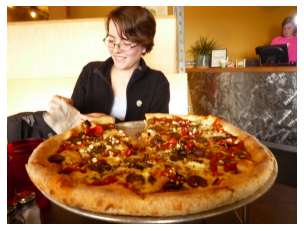

In [109]:
img_show_2(temp_obj_img)

- background image selection

In [110]:
import json

json_path = './data/OPS300.json'
with open(json_path, 'r') as f:
    json_data = json.load(f)

print(json.dumps(json_data))

keys = [key for key in json_data]

random.seed(42)
cat = random.sample(keys, 1)
print(cat[0])

cat_list = json_data[cat[0]]
bg_cat = random.sample(cat_list, 1)
temp_bg_file_name = bg_cat[0]
temp_bg_file_name

{"mountain": ["./data/OutdooSceneTrain_v2/mountain/mountain_833.png", "./data/OutdooSceneTrain_v2/mountain/mountain_493.png", "./data/OutdooSceneTrain_v2/mountain/mountain_35.png", "./data/OutdooSceneTrain_v2/mountain/mountain_950.png", "./data/OutdooSceneTrain_v2/mountain/mountain_445.png", "./data/OutdooSceneTrain_v2/mountain/mountain_592.png", "./data/OutdooSceneTrain_v2/mountain/mountain_223.png", "./data/OutdooSceneTrain_v2/mountain/mountain_372.png", "./data/OutdooSceneTrain_v2/mountain/mountain_1044.png", "./data/OutdooSceneTrain_v2/mountain/mountain_125.png"], "sky": ["./data/OutdooSceneTrain_v2/sky/cloud_008.png", "./data/OutdooSceneTrain_v2/sky/sky_122.png", "./data/OutdooSceneTrain_v2/sky/sky_1196.png", "./data/OutdooSceneTrain_v2/sky/sky_1271.png", "./data/OutdooSceneTrain_v2/sky/cloud_029.png", "./data/OutdooSceneTrain_v2/sky/sky_1126.png", "./data/OutdooSceneTrain_v2/sky/cloud_013.png", "./data/OutdooSceneTrain_v2/sky/sky_1279.png", "./data/OutdooSceneTrain_v2/sky/sky_115

'./data/OutdooSceneTrain_v2/water/water_115.png'

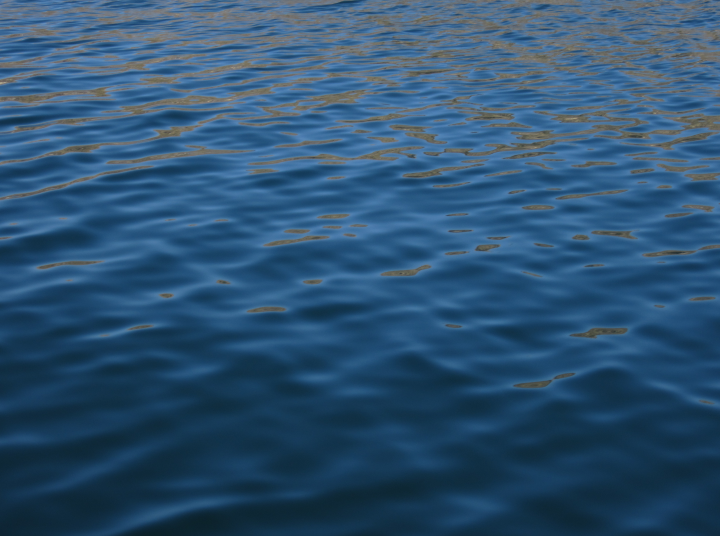

In [111]:
import IPython.display as display
from PIL import Image

img = Image.open(temp_bg_file_name)
display.display(img)

In [112]:
temp_bg_img = cv2.imread(temp_bg_file_name, cv2.IMREAD_COLOR)
temp_bg_img = cv2.cvtColor(temp_bg_img, cv2.COLOR_BGR2RGB)

- image augmentation

In [113]:
def bbox_point(bboxes):
    y_up = int(bboxes[1])
    y_down = y_up + int(bboxes[3])
    x_left = int(bboxes[0])
    x_right = x_left + int(bboxes[2])
    return x_left,x_right,y_up,y_down
def __cut_obj__(bboxes, img, obj_bg: str):
    x_left,x_right,y_up,y_down = bbox_point(bboxes)
    if obj_bg == "obj":
        result = np.array(img)[y_up:y_down,x_left:x_right,:]
    # if obj_bg is bg return out area of image
    elif obj_bg == "bg":
        result = np.array(img)
        result[y_up:y_down,x_left:x_right,:] = 0
    return result 
def __resize__(obj_img, bg_img, size, bbox):
    # img resize
    width_ratio, height_ratio = size[0] / obj_img.shape[1], size[1] / obj_img.shape[0]
    obj_img = cv2.resize(obj_img, size, interpolation=cv2.INTER_CUBIC)
    bg_img = cv2.resize(bg_img, size, interpolation=cv2.INTER_CUBIC)
    bbox = [bbox[0] * width_ratio, bbox[1] * height_ratio, bbox[2] * width_ratio, bbox[3] * height_ratio]
    return obj_img, bg_img, bbox
def __paste_obj__(bboxes, bg_img, obj_img):
    x_left, x_right, y_up, y_down = bbox_point(bboxes)
    bg_img[y_up:y_down, x_left:x_right, :] = obj_img
    return bg_img

In [114]:
temp_obj_img_rs, temp_bg_img_rs, temp_obj_bbox_rs = __resize__(temp_obj_img, temp_bg_img, size=(384,384), bbox=temp_obj_bbox)

In [115]:
temp_obj_img_obj = __cut_obj__(temp_obj_bbox_rs, temp_obj_img_rs, "obj")
temp_obj_img_bg = __cut_obj__(temp_obj_bbox_rs, temp_obj_img_rs, "bg")

In [116]:
temp_obj_img_obj.shape

(192, 384, 3)

In [117]:
temp_obj_img_bg.shape

(384, 384, 3)

In [118]:
def bbox_point(bboxes):
    y_up = int(bboxes[1])
    y_down = y_up + int(bboxes[3])
    x_left = int(bboxes[0])
    x_right = x_left + int(bboxes[2])
    return x_left,x_right,y_up,y_down

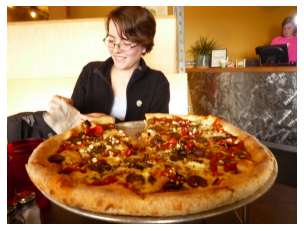

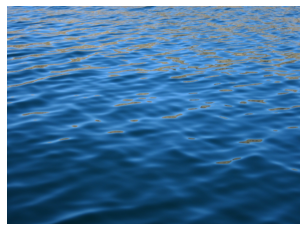

In [119]:
temp_obj_img_obj = __cut_obj__(temp_obj_bbox_rs, temp_obj_img_rs, "obj")
temp_obj_img_bg = __cut_obj__(temp_obj_bbox_rs, temp_obj_img_rs, "bg")

img = 0.3 * temp_obj_img_bg + 0.7 * temp_bg_img_rs
img_show_2(temp_obj_img)
img_show_2(temp_bg_img)

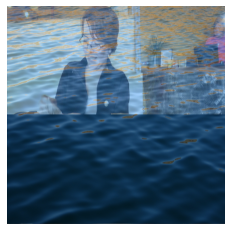

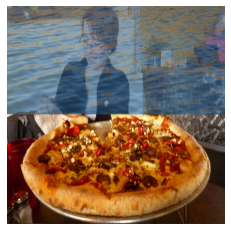

In [120]:
img_show_2(img)
img = __paste_obj__(temp_obj_bbox_rs, img, temp_obj_img_obj)
img_show_2(img)

In [121]:
temp_obj_img_obj.shape

(192, 384, 3)

### RobustMixGen : Image Augmentation

In [138]:
# RoMixGen_Img : Image Augmentation 진행 (background 이미지 획득)
# Concat with original object images [bounding box]
class RoMixGen_Img_aug:
    def __init__(self, image_root, bg_image_root, transform_after_mix, resize_ratio=1, img_mix = False,  obj_bg_mix_ratio=0.5):
    
        # Image 
        self.image_root          = image_root                   # augmentation에 대해 전처리 진행 
        self.bg_image_root       = bg_image_root
        self.transform_after_mix = transform_after_mix          # transforms functions after augmentation 
        self.resize_ratio        = resize_ratio     
        self.img_mix             = img_mix                      # how large obj image resized 
        self.img_mix_ratio       = obj_bg_mix_ratio             # if True, mix image with image

    def __get_dict__(self, img_info, bg_img_info):
        self.img_info_dict = img_info                            # 얼마나 크게 오브젝트 객체가 resize 될지 확인 진행 
        self.bg_img_info = bg_img_info  

    def bbox_point(self,bboxes):
        y_up = int(bboxes[1])
        y_down = y_up + int(bboxes[3])
        x_left = int(bboxes[0])
        x_right = x_left + int(bboxes[2])
        return x_left,x_right,y_up,y_down
    
    def __cut_obj__(self, bboxes, obj_img, obj_bg:str):
        x_left, x_right, y_up, y_down = self.bbox_point(bboxes)
        if obj_bg == "obj":
            result = np.array(obj_img)[y_up:y_down,x_left:x_right,:]
        elif obj_bg == "bg":
            result = np.array(obj_img)
            result[y_up:y_down,x_left:x_right,:] = 0
        return result 
    
    def __paste_obj__(self, bboxes, bg_img, obj_img):
        x_left, x_right, y_up, y_down = self.bbox_point(bboxes)
        bg_img[y_up:y_down, x_left:x_right, :] = obj_img
        return bg_img
       
    def get_xy_point(self,bg_img,obj_img,bg_inform):
        (bg_y,bg_x,_) = np.array(bg_img).shape
        (obj_y,obj_x,_) = np.array(obj_img).shape
        [bg_midpoint_x,bg_midpoint_y] = bg_inform['max_obj_midpoint']

        # 검정박스 우측 아래 -> 우측 아래 코너에 맞춤 진행
        if  (bg_midpoint_y > bg_y/2) & (bg_midpoint_x > bg_x/2):
            # 오른쪽 아래 
            y = bg_inform['max_obj_bbox'][1] + bg_inform['max_obj_bbox'][3]
            x = bg_inform['max_obj_bbox'][0] + bg_inform['max_obj_bbox'][2]
            x,y = x - obj_x , y - obj_y
        # 검정박스 좌측 아래 -> 좌측 아래 코너에 맞춤 진행
        elif  (bg_midpoint_y > bg_y/2) & (bg_midpoint_x < bg_x/2):
            # 좌측 아래
            y = bg_inform['max_obj_bbox'][1] + bg_inform['max_obj_bbox'][3]
            x = bg_inform['max_obj_bbox'][0] 
            y =  y - obj_y
            
        # 검정박스 우측 위 -> 우측 위 코너에 맞춤 진행
        elif  (bg_midpoint_y < bg_y/2) & (bg_midpoint_x > bg_x/2):
            # 오른쪽 위
            y = bg_inform['max_obj_bbox'][1] 
            x = bg_inform['max_obj_bbox'][0] + bg_inform['max_obj_bbox'][2]
            x = x - obj_x 
            
        # 검정박스 좌측 위 -> 좌측 위 코너에 맞춤 진행
        else:
            # 좌측 위
            y = bg_inform['max_obj_bbox'][1] 
            x = bg_inform['max_obj_bbox'][0] 
            
        return x,y 
    
    def __resize__(self, obj_img, bg_img, size=(384,384)):
        # img resize
        width_ratio, height_ratio = size[0] / obj_img.shape[1], size[1] / obj_img.shape[0]
        obj_img = cv2.resize(obj_img, size, interpolation=cv2.INTER_CUBIC)
        bg_img = cv2.resize(bg_img, size, interpolation=cv2.INTER_CUBIC)
        resized_bbox = [self.obj_inform["max_obj_bbox"][0] * width_ratio, self.obj_inform["max_obj_bbox"][1] * height_ratio, self.obj_inform["max_obj_bbox"][2] * width_ratio, self.obj_inform["max_obj_bbox"][3] * height_ratio]
        return obj_img, bg_img, resized_bbox
    
    def __call__(self,obj_id,bg_id):
        self.obj_inform = self.img_info_dict[obj_id] # 이미지 전처리 정보 중 해당 img(이미지)의 정보를 가져옴
        self.bg_inform  = self.bg_img_info_dict[bg_id]  # 이미지 전처리 정보 중 해당 bg(배경)의 정보를 가져옴 
        
        # image open with cv2 and resize to 384*384
        # cv2 
        
        if self.img_mix:
            obj_img = cv2.imread(os.path.join(self.image_root, self.obj_inform['file_name']))
            bg_img  = cv2.imread(os.path.join(self.bg_image_root, self.bg_inform['file_name']))
            obj_img, bg_img = cv2.cvtColor(obj_img, cv2.COLOR_BGR2RGB), cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
            # 불러오기 완료
            # 배경 이미지에서 obj가 있는 부분을 잘라냄

            # 수정해야되는 부분 : 
            # bg_img =  self.__cut_obj__(self.bg_inform["max_obj_bbox"], bg_img, "bg")
            obj_img, bg_img, obj_bbox = self.__resize__(obj_img, bg_img,(512,512))
            obj_img_obj = self.__cut_obj__(obj_bbox, obj_img, "obj")
            obj_img_bg = self.__cut_obj__(obj_bbox, obj_img, "bg")

            img = (1 - self.img_mix_ratio) * obj_img_bg + self.img_mix_ratio * bg_img
            #regularization
            img = self.__paste_obj__(obj_bbox, img, obj_img_obj)
            # numpy array to PIL image
            img = Image.fromarray(img.astype(np.uint8))
            img = self.transform_after_mix(img)

        else:
            obj_img = Image.open(os.path.join(self.image_root, self.obj_inform['file_name'])).convert('RGB')
            bg_img  = Image.open(os.path.join(self.bg_image_root, self.bg_inform['file_name'])).convert('RGB')
            x,y = self.get_xy_point(bg_img,obj_img,self.bg_inform)
            bg_img.paste(obj_img,(int(x),int(y)))
            img = self.transform_after_mix(bg_img)
        return img 


In [143]:
image_root = './data/COCO/Annotations'
bg_image_root = './data/OutdooSceneTrain_v2/'


bg_json_path = bg_image_root + 'total_sample_ops300.json'
with open(bg_json_path, 'r') as f:
    bg_json_data = json.load(f)
bg_json_data


[{'file_name': 'mountain_833.png',
  'category': 'mountain',
  'sub_category': 'mountain',
  'id': 'mountain_833',
  'bounding_box': [0, 0, 0, 0]},
 {'file_name': 'mountain_493.png',
  'category': 'mountain',
  'sub_category': 'mountain',
  'id': 'mountain_493',
  'bounding_box': [0, 0, 0, 0]},
 {'file_name': 'mountain_35.png',
  'category': 'mountain',
  'sub_category': 'mountain',
  'id': 'mountain_35',
  'bounding_box': [0, 0, 0, 0]},
 {'file_name': 'mountain_950.png',
  'category': 'mountain',
  'sub_category': 'mountain',
  'id': 'mountain_950',
  'bounding_box': [0, 0, 0, 0]},
 {'file_name': 'mountain_445.png',
  'category': 'mountain',
  'sub_category': 'mountain',
  'id': 'mountain_445',
  'bounding_box': [0, 0, 0, 0]},
 {'file_name': 'mountain_592.png',
  'category': 'mountain',
  'sub_category': 'mountain',
  'id': 'mountain_592',
  'bounding_box': [0, 0, 0, 0]},
 {'file_name': 'mountain_223.png',
  'category': 'mountain',
  'sub_category': 'mountain',
  'id': 'mountain_223',

In [ ]:
obj_json_path = image_root + 'total_sample_ops300.json'
with open(obj_json_path, 'r') as f:
    obj_json_data = json.load(f)
obj_json_data

#### Caption generation 진행 : **augmentation**

In [125]:
preposition_list = ['At', 'In']

random.seed(42)
pre = random.sample(preposition_list, 1)
cap = random.sample(img_info_dict_fixed[temp_obj_id]['captions'], 1)
text = pre[0] + ' ' + cat[0] + ', ' + cap[0] # object caption 중 하나 선택하여 합성 진행
text

'At water, A woman sitting in front of a giant pizza.'

#### Background 이미지 다시 받아오기 진행
- Text augmentation 만들기 [완료]

In [133]:
# 백그라운드에 대해 텍스트 어그멘테션 진행 + 이미지 받아오기 : 백그라운드 이미지에 오브젝트 붙이기 실시
# background에 대해 text augmentation 진행 : object 이미지 받아오기
# backgound 이미지에 object 이미지의 bounding box를 이용하여 붙이는 과정 진행
# This is 완성본s
class RoMixGen_Txt_aug:
    def __init__(self): 
        pass

    def __get_dict__(self, img_info, bg_img_info):
        self.img_info_dict = img_info
        self.bg_img_info = bg_img_info
    
    # 단어 대체 모듈을 이용하여 단어 교체 실시 진행
    # def replace_word(self,captions,bg_cats,obj_cats):
    #     caption = np.random.choice(captions,1)[0]
    #     '''
    #     replaced = False 
    #     for bg_cat, obj_cat in zip(bg_cats,obj_cats):
    #         if bg_cat in caption:
    #             caption = caption.replace(bg_cat, obj_cat)
    #             print('True')
    #             replaced = True 
    #             break
    #     if not replaced:
    #         caption = random.choice(obj_cats) + " " + caption
    #     '''
    #     try:
    #         (bg_cat_id, bg_cat) = list(filter(lambda x : x[1] in caption.lower(), enumerate(bg_cats)))[0]
    #         caption = caption.lower().replace(bg_cat,obj_cats[bg_cat_id]).capitalize()
    #     except IndexError:
    #         caption = random.choice(obj_cats) + " " + caption
    #     return caption 
    
    def mix_caption (self, obj_caption, bg_cat):
        obj_cap = random.sample(obj_caption, 1)[0]
        obj_cap = obj_cap.lower()
        bg_cat = bg_cat.lower()


        preposition_list = ['At', 'In']
        pre = random.sample(preposition_list, 1)[0]

        return pre + " " + bg_cat + ", " + obj_cap

    # object와 background id에 대해 concatenation 진행
    def __call__(self,obj_id,bg_id):
        # obj_cat = self.img_info_dict[obj_id]["max_obj_cat"] + self.img_info_dict[obj_id]["max_obj_super_cat"]
        obj_caption = self.img_info_dict[obj_id]["captions"]        
        
        # background dictionary 생성
        bg_cat = self.bg_img_info[bg_id]["category"]

        # bg_cat = self.img_info_dict[bg_id]["max_obj_cat"] + self.img_info_dict[bg_id]["max_obj_super_cat"]
        # bg_caption = self.img_info_dict[bg_id]["captions"]

        self.bg_cat = bg_cat
        obj_caption = self.img_info_dict[obj_id]["captions"]
        self.obj_cat = obj_cat
        new_caption = self.mix_caption(obj_caption, bg_cat)

        return new_caption

In [134]:
# 전치사 이용하여 캡션에 변형 주기
preposition_list = ['At', 'In']

random.seed(42)
pre = random.sample(preposition_list, 1)[0]
cap = random.sample(img_info_dict_fixed[temp_obj_id]['captions'], 1)
text = pre[0] + ' ' + cat[0] + ', ' + cap[0] # object caption 중 하나 선택하여 합성 진행
text

'A water, A woman sitting in front of a giant pizza.'

In [135]:
# object에 해당되는 bbox point 찾기
# 오브젝트에 해당되는 bounding box point 찾기
# 4개의 좌표값 설정
x_left,x_right,y_up,y_down = bbox_point(temp_obj_bbox_rs)
print(x_left, x_right, y_up, y_down)

0 384 191 383


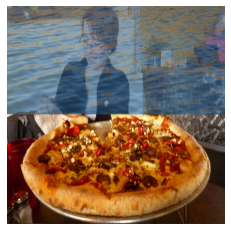

In [136]:
# object의 bounding box 및 기본 이미지에 대한 정보 업로드
imag = __paste_obj__(temp_obj_bbox_rs, img, temp_obj_img_obj)
img_show_2(imag)

#### Image augmentation 실행 : object와 background 합성

In [137]:
class RMG_Img_aug:
    def __init__(self, image_root, transform_after_mix, resize_ratio=1, img_mix = False,  obj_bg_mix_ratio=0.5):
    
        # Image 
        self.image_root          = image_root                   # preprocessed image for augmentation root 
        self.transform_after_mix = transform_after_mix # transforms functions after augmentation 
        self.resize_ratio        = resize_ratio     
        self.img_mix             = img_mix              # 얼마나 크게 이미지 오브젝트가 resize 될 수 있는지
        self.img_mix_ratio       = obj_bg_mix_ratio     # True이면,이미지를 다른 이미지들과 mix

    def __get_dict__(self, img_info):
        self.img_info_dict = img_info  # 이미지의 오브젝트를 얼마나 잘 resize 할 수 있는지 확인

    def bbox_point(self,bboxes):
        y_up = int(bboxes[1])
        y_down = y_up + int(bboxes[3])
        x_left = int(bboxes[0])
        x_right = x_left + int(bboxes[2])
        return x_left,x_right,y_up,y_down
    
    def __cut_obj__(self, bboxes, obj_img, obj_bg:str):
        x_left, x_right, y_up, y_down = self.bbox_point(bboxes)
        if obj_bg == "obj":
            result = np.array(obj_img)[y_up:y_down,x_left:x_right,:]
        elif obj_bg == "bg":
            result = np.array(obj_img)
            result[y_up:y_down,x_left:x_right,:] = 0
        return result 
    
    def __paste_obj__(self, bboxes, bg_img, obj_img):
        x_left, x_right, y_up, y_down = self.bbox_point(bboxes)
        bg_img[y_up:y_down, x_left:x_right, :] = obj_img
        return bg_img
       
    def get_xy_point(self,bg_img,obj_img,bg_inform):
        (bg_y,bg_x,_) = np.array(bg_img).shape
        (obj_y,obj_x,_) = np.array(obj_img).shape
        [bg_midpoint_x,bg_midpoint_y] = bg_inform['max_obj_midpoint']

        # 검정박스 우측 아래 -> 우측 아래 코너에 맞춰 진행
        if  (bg_midpoint_y > bg_y/2) & (bg_midpoint_x > bg_x/2):
            # 오른쪽 아래 
            y = bg_inform['max_obj_bbox'][1] + bg_inform['max_obj_bbox'][3]
            x = bg_inform['max_obj_bbox'][0] + bg_inform['max_obj_bbox'][2]
            x,y = x - obj_x , y - obj_y
        # 검정박스 좌측 아래 -> 좌측 아래 코너에 맞춰 진행
        elif  (bg_midpoint_y > bg_y/2) & (bg_midpoint_x < bg_x/2):
            # 좌측 아래
            y = bg_inform['max_obj_bbox'][1] + bg_inform['max_obj_bbox'][3]
            x = bg_inform['max_obj_bbox'][0] 
            y =  y - obj_y
            
        # 검정박스 우측 위 -> 우측 위 코너에 맞춰 진행
        elif  (bg_midpoint_y < bg_y/2) & (bg_midpoint_x > bg_x/2):
            # 오른쪽 위
            y = bg_inform['max_obj_bbox'][1] 
            x = bg_inform['max_obj_bbox'][0] + bg_inform['max_obj_bbox'][2]
            x = x - obj_x 
            
        # 검정박스 좌측 위 -> 좌측 위 코너에 맞춰 진행 
        else:
            # 좌측 위
            y = bg_inform['max_obj_bbox'][1] 
            x = bg_inform['max_obj_bbox'][0] 
            
        return x,y 

- text augmentation

In [131]:
# 위에서 추출한 background에 대한 라벨값
cat

['water']

In [132]:
# print : object_id
temp_obj_id

'361238'

In [46]:
img_info_dict_fixed[temp_obj_id]['captions']

['A woman sitting in front of a giant pizza.',
 'The girl with glasses is eating a slice of pizza.',
 'a very large pizza that is on some kind of pizza pan',
 'a woman in a black jacket and a pizza ',
 'A pizza with a slice missing is sitting on a pizza stand.']

In [47]:
preposition_list = ['At', 'In']

random.seed(42)
pre = random.sample(preposition_list, 1)
cap = random.sample(img_info_dict_fixed[temp_obj_id]['captions'], 1)
text = pre[0] + ' ' + cat[0] + ', ' + cap[0] # object caption 중 하나 선택하여 합성 진행
text

'At water, A woman sitting in front of a giant pizza.'